In [121]:
# Author: Hassan Ali

# Problem 2: Analysis of Hate Crimes Data
#
# Examinging state level hate crime data from two primary sources:
# - SPLC hate crimes per 100k (collected Nov. 9–18, 2016)
# - FBI average annual hate crimes per 100k (2010–2015)
#
# Adressing key questions:
#
# 1. Income Inequality and Hate Crimes:
#    How does income inequality (measured by the Gini index) relate to hate crime rates?
#
# 2. Predicting Hate Crimes from Demographic Factors:
#    How can we predict hate crime rates using variables that capture racial and socio-economic conditions?
#
# 3. State Level Variation and Similarity:
#    How do hate crime rates vary across states, and do states group together based on these metrics?
#
# Utilizing correlation analysis, OLS regression, multiple linear regression (MLR), bar plots, clustering, and additional visualizations (including actual vs. predicted plots and a 3D regression plane) to comprehensively answer these questions.


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [123]:
# Loading Data and Preprocessing

file_path = 'hatecrime.csv'
df = pd.read_csv(file_path)

# Printing dataset shape and first rows
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (51, 12)
        state  median_household_income  share_unemployed_seasonal  \
0     Alabama                    42278                      0.060   
1      Alaska                    67629                      0.064   
2     Arizona                    49254                      0.063   
3    Arkansas                    44922                      0.052   
4  California                    60487                      0.059   

   share_population_in_metro_areas  share_population_with_high_school_degree  \
0                             0.64                                     0.821   
1                             0.63                                     0.914   
2                             0.90                                     0.842   
3                             0.69                                     0.824   
4                             0.97                                     0.806   

   share_non_citizen  share_white_poverty  gini_index  share_non_white  \
0     

In [125]:
# Question 1: Income Inequality and Hate Crimes
#
# Step 1: Correlation Analysis
#
# Calculating Pearson correlations between:
# - **Gini index** and **SPLC hate crimes**
# - **Gini index** and **FBI hate crimes**


corr_splc = df['gini_index'].corr(df['hate_crimes_per_100k_splc'])
corr_fbi = df['gini_index'].corr(df['avg_hatecrimes_per_100k_fbi'])

print("Correlation between Gini index and SPLC hate crimes:", corr_splc)
print("Correlation between Gini index and FBI hate crimes:", corr_fbi)

Correlation between Gini index and SPLC hate crimes: 0.3294393255018238
Correlation between Gini index and FBI hate crimes: 0.4212718629058918


In [127]:
# Step 2: Regression Models
#
# Building two separate OLS regression models with the Gini index as the sole predictor.
#
# **SPLC Model:**
# \[
# \hat{y}_{SPLC} = \beta_0 + \beta_1 \times \text{gini\_index}
# \]
#
# **FBI Model:**
# \[
# \hat{y}_{FBI} = \beta_0 + \beta_1 \times \text{gini\_index}
# \]
#
# Dropping any rows with missing values in the relevant columns to avoid NaN issues.


# --- SPLC Regression Model ---
df_reg_splc = df[['gini_index', 'hate_crimes_per_100k_splc']].dropna()
X_gini_splc = sm.add_constant(df_reg_splc['gini_index'])
y_splc = df_reg_splc['hate_crimes_per_100k_splc']

# Fit the OLS model
ols_model_splc = sm.OLS(y_splc, X_gini_splc).fit()
y_splc_pred = ols_model_splc.predict(X_gini_splc)

# Compute MSE and R²
mse_splc = mean_squared_error(y_splc, y_splc_pred)
r2_splc = r2_score(y_splc, y_splc_pred)

print("\n--- SPLC Regression Model ---")
print(ols_model_splc.summary())  # Full OLS summary
print("MSE:", mse_splc)
print("R²:", r2_splc)

# --- FBI Regression Model ---
df_reg_fbi = df[['gini_index', 'avg_hatecrimes_per_100k_fbi']].dropna()
X_gini_fbi = sm.add_constant(df_reg_fbi['gini_index'])
y_fbi = df_reg_fbi['avg_hatecrimes_per_100k_fbi']

# Fit the OLS model
ols_model_fbi = sm.OLS(y_fbi, X_gini_fbi).fit()
y_fbi_pred = ols_model_fbi.predict(X_gini_fbi)

# Compute MSE and R²
mse_fbi = mean_squared_error(y_fbi, y_fbi_pred)
r2_fbi = r2_score(y_fbi, y_fbi_pred)

print("\n--- FBI Regression Model ---")
print(ols_model_fbi.summary())  # Full OLS summary
print("MSE:", mse_fbi)
print("R²:", r2_fbi)


--- SPLC Regression Model ---
                                OLS Regression Results                               
Dep. Variable:     hate_crimes_per_100k_splc   R-squared:                       0.109
Model:                                   OLS   Adj. R-squared:                  0.089
Method:                        Least Squares   F-statistic:                     5.478
Date:                       Tue, 18 Feb 2025   Prob (F-statistic):             0.0237
Time:                               20:02:06   Log-Likelihood:                 1.1644
No. Observations:                         47   AIC:                             1.671
Df Residuals:                             45   BIC:                             5.371
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

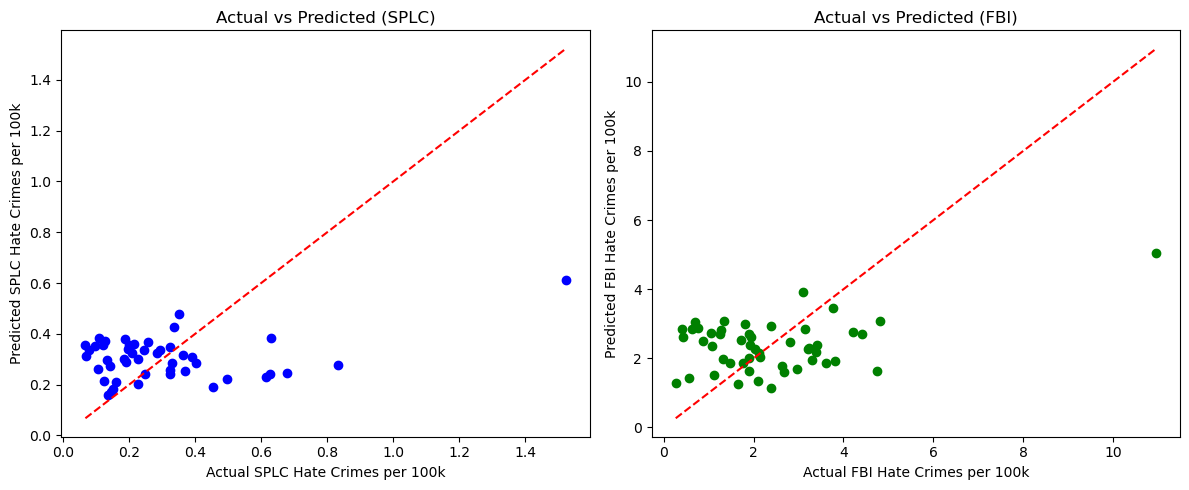

In [129]:
# Actual vs. Predicted Plots (SPLC and FBI)
#
# Generating side-by-side scatter plots to compare actual vs. predicted values for both models.


plt.figure(figsize=(12, 5))

# Left: SPLC
plt.subplot(1, 2, 1)
plt.scatter(y_splc, y_splc_pred, color='blue')
plt.plot([y_splc.min(), y_splc.max()], [y_splc.min(), y_splc.max()], 'r--')
plt.xlabel('Actual SPLC Hate Crimes per 100k')
plt.ylabel('Predicted SPLC Hate Crimes per 100k')
plt.title('Actual vs Predicted (SPLC)')

# Right: FBI
plt.subplot(1, 2, 2)
plt.scatter(y_fbi, y_fbi_pred, color='green')
plt.plot([y_fbi.min(), y_fbi.max()], [y_fbi.min(), y_fbi.max()], 'r--')
plt.xlabel('Actual FBI Hate Crimes per 100k')
plt.ylabel('Predicted FBI Hate Crimes per 100k')
plt.title('Actual vs Predicted (FBI)')

plt.tight_layout()
plt.show()

In [131]:
# Analysis for Question 1:
# - The correlation between the Gini index and SPLC hate crimes is around 0.329, and with FBI hate crimes is around 0.421.
# - The SPLC regression model suggests that a one-unit increase in the Gini index predicts about 4.02 additional hate crimes per 100k (R² ~10.9%).
# - The FBI regression model suggests about 34.57 additional hate crimes per 100k for each one-unit increase in the Gini index (R² ~17.7%).
# - The OLS summaries and actual vs. predicted plots show that while there is a positive relationship, the Gini index alone explains only a modest portion of the variance in hate crime rates.


# Question 2: Predicting Hate Crimes from Demographic Variables
#
# Predicting hate crime rates (SPLC) using demographic factors.
#
# Chosen Predictors:
# - **share_non_white**
# - **share_non_citizen**
# - **share_white_poverty**
#
# These variables should capture key aspects of racial diversity and economic conditions.


predictors = ['share_non_white', 'share_non_citizen', 'share_white_poverty']
df_reg_dem = df[predictors + ['hate_crimes_per_100k_splc']].dropna()

# Prepare data
X_dem = sm.add_constant(df_reg_dem[predictors])
y_dem = df_reg_dem['hate_crimes_per_100k_splc']

# Fit the MLR model
mlr_model = sm.OLS(y_dem, X_dem).fit()
y_dem_pred = mlr_model.predict(X_dem)

# Compute MSE and R²
mse_dem = mean_squared_error(y_dem, y_dem_pred)
r2_dem = r2_score(y_dem, y_dem_pred)

print("\n--- MLR Model (Demographic Predictors for SPLC Hate Crimes) ---")
print(mlr_model.summary())  # Full OLS report
print("MSE:", mse_dem)
print("R²:", r2_dem)


--- MLR Model (Demographic Predictors for SPLC Hate Crimes) ---
                                OLS Regression Results                               
Dep. Variable:     hate_crimes_per_100k_splc   R-squared:                       0.121
Model:                                   OLS   Adj. R-squared:                  0.057
Method:                        Least Squares   F-statistic:                     1.878
Date:                       Tue, 18 Feb 2025   Prob (F-statistic):              0.148
Time:                               20:02:07   Log-Likelihood:                 1.6539
No. Observations:                         45   AIC:                             4.692
Df Residuals:                             41   BIC:                             11.92
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                          coef    std err          t      P>|t|      [0.025

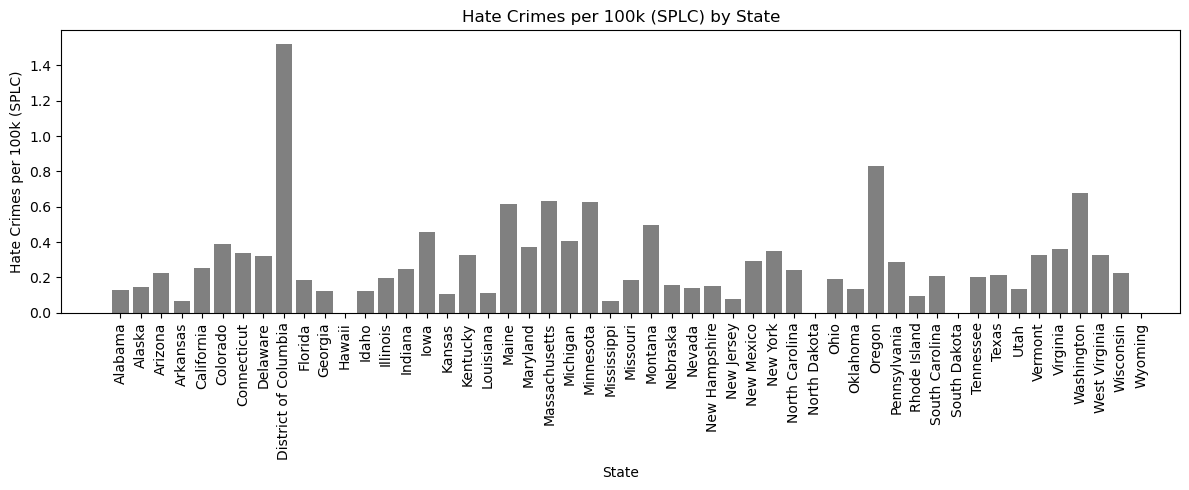

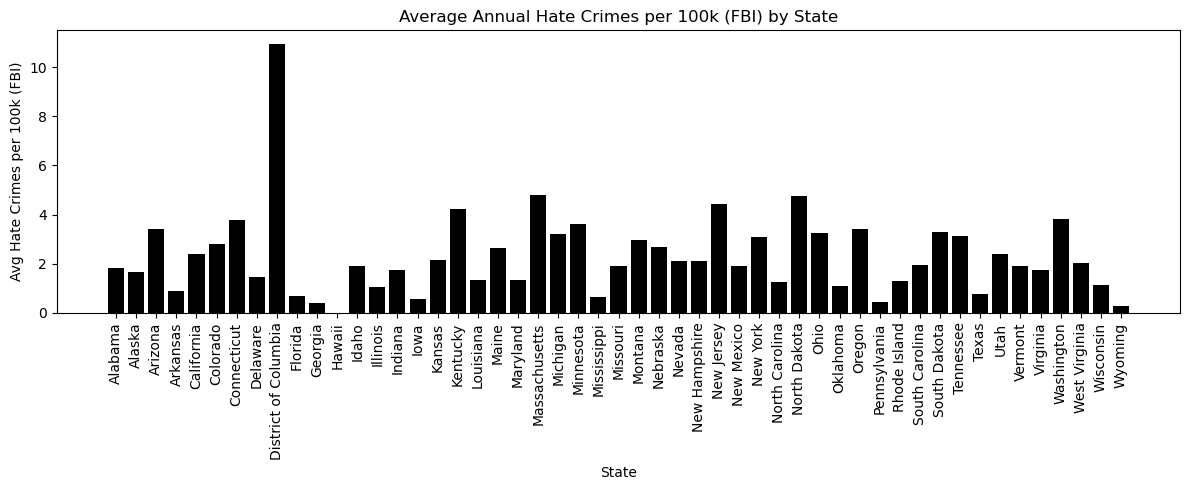

In [133]:
# Analysis for Question 2:
# The MLR model indicates that the chosen demographic variables moderately predict hate crimes (SPLC) (R² ~12%). Additional variables may be needed for a more comprehensive model.


# Question 3: State-Level Variation and Similarity Analysis
#
# Examine how hate crime rates vary across states and determine whether states group together based on these metrics.
#
# 1. Visualization: Create bar plots for SPLC and FBI hate crimes by state.
# 2. Clustering: Apply k-Means clustering to the two hate crime metrics.
# 3. 3D Visualization: Fit a regression model to predict median household income from the two hate crime metrics, and plot a 3D regression plane.

# Bar plots for SPLC and FBI hate crimes by state.
plt.figure(figsize=(12, 5))
plt.bar(df['state'], df['hate_crimes_per_100k_splc'], color='grey')
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Hate Crimes per 100k (SPLC)')
plt.title('Hate Crimes per 100k (SPLC) by State')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(df['state'], df['avg_hatecrimes_per_100k_fbi'], color='black')
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Avg Hate Crimes per 100k (FBI)')
plt.title('Average Annual Hate Crimes per 100k (FBI) by State')
plt.tight_layout()
plt.show()



Cluster assignments by state:
                   state  cluster
0                Alabama        0
27              Nebraska        0
28                Nevada        0
29         New Hampshire        0
30            New Jersey        0
31            New Mexico        0
33        North Carolina        0
35                  Ohio        0
25              Missouri        0
36              Oklahoma        0
39          Rhode Island        0
40        South Carolina        0
42             Tennessee        0
43                 Texas        0
44                  Utah        0
45               Vermont        0
46              Virginia        0
38          Pennsylvania        0
48         West Virginia        0
24           Mississippi        0
10               Georgia        0
1                 Alaska        0
2                Arizona        0
3               Arkansas        0
4             California        0
7               Delaware        0
9                Florida        0
20              M

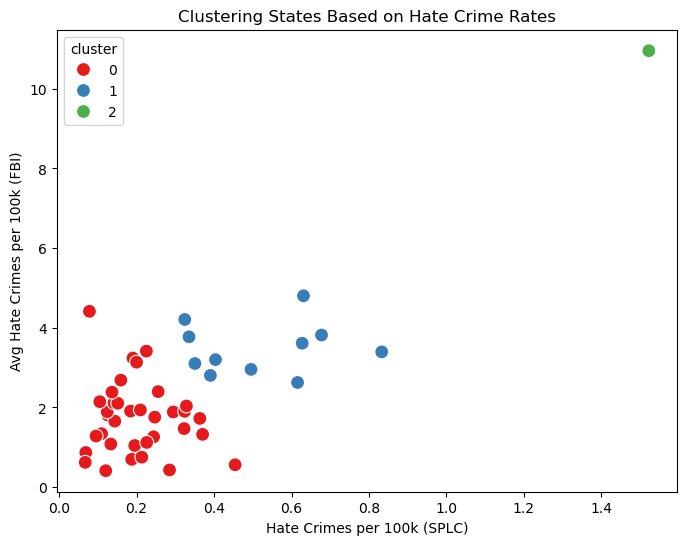

In [134]:
# Clustering Analysis
# Drop rows with missing values for the relevant columns.
df_cluster = df[['state', 'hate_crimes_per_100k_splc', 'avg_hatecrimes_per_100k_fbi', 'median_household_income']].dropna()

X_cluster = df_cluster[['hate_crimes_per_100k_splc', 'avg_hatecrimes_per_100k_fbi']]
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

kmeans_cluster = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans_cluster.fit_predict(X_cluster_scaled)
df_cluster['cluster'] = cluster_labels

print("\nCluster assignments by state:")
print(df_cluster[['state', 'cluster']].sort_values('cluster'))

# Scatter plot to visualize clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='hate_crimes_per_100k_splc',
                y='avg_hatecrimes_per_100k_fbi',
                hue='cluster',
                data=df_cluster,
                palette='Set1',
                s=100)
plt.title('Clustering States Based on Hate Crime Rates')
plt.xlabel('Hate Crimes per 100k (SPLC)')
plt.ylabel('Avg Hate Crimes per 100k (FBI)')
plt.show()




Regression model for Median Household Income:
const                          50369.973361
hate_crimes_per_100k_splc       9439.042756
avg_hatecrimes_per_100k_fbi      666.960684
dtype: float64


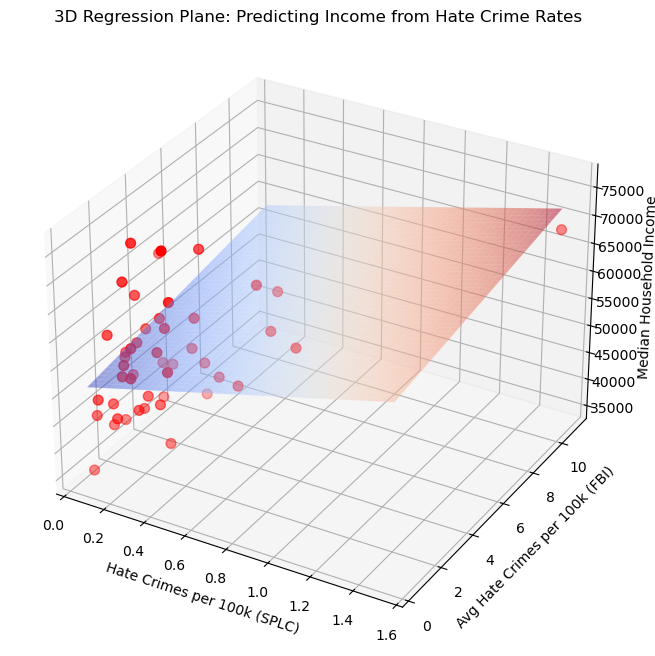

In [137]:
# 3D Regression Plane for Median Household Income
# Fit a model: median_household_income ~ b0 + b1*(hate_crimes_per_100k_splc) + b2*(avg_hatecrimes_per_100k_fbi)
X_plane = df_cluster[['hate_crimes_per_100k_splc', 'avg_hatecrimes_per_100k_fbi']]
X_plane_const = sm.add_constant(X_plane)
y_income = df_cluster['median_household_income']

plane_model = sm.OLS(y_income, X_plane_const).fit()
print("\nRegression model for Median Household Income:")
print(plane_model.params)

# Create a meshgrid for the two hate crime metrics
x_vals = np.linspace(X_plane['hate_crimes_per_100k_splc'].min(), X_plane['hate_crimes_per_100k_splc'].max(), 50)
y_vals = np.linspace(X_plane['avg_hatecrimes_per_100k_fbi'].min(), X_plane['avg_hatecrimes_per_100k_fbi'].max(), 50)
X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)
Z_mesh = (plane_model.params['const'] +
          plane_model.params['hate_crimes_per_100k_splc'] * X_mesh +
          plane_model.params['avg_hatecrimes_per_100k_fbi'] * Y_mesh)

# 3D visualization
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap='coolwarm', alpha=0.5, linewidth=0, antialiased=True)
ax.scatter(df_cluster['hate_crimes_per_100k_splc'],
           df_cluster['avg_hatecrimes_per_100k_fbi'],
           df_cluster['median_household_income'],
           color='red', s=50)
ax.set_xlabel('Hate Crimes per 100k (SPLC)')
ax.set_ylabel('Avg Hate Crimes per 100k (FBI)')
ax.set_zlabel('Median Household Income')
ax.set_title('3D Regression Plane: Predicting Income from Hate Crime Rates')
plt.show()

In [118]:
# Final Analysis and Conclusion
#
# Question 1 (Income Inequality):
# - The Gini index is moderately correlated with hate crimes (~0.329 for SPLC and ~0.421 for FBI).
# - The SPLC regression model suggests that a one-unit increase in the Gini index predicts ~4.02 additional hate crimes per 100k (R² ~10.9%).
# - The FBI regression model indicates ~34.57 additional hate crimes per 100k for each one-unit increase in the Gini index (R² ~17.7%).
#
# Question 2 (Demographic Predictors):
# - The MLR model (using share_non_white, share_non_citizen, share_white_poverty) explains about 12% of the variance in SPLC hate crimes.
#
# Question 3 (State-Level Variation):
# - Bar plots show significant variation in hate crime rates across states.
# - k-Means clustering (k=3) groups states into distinct clusters based on the two hate crime metrics.
# - A 3D regression plane provides insight into how median household income can be predicted from hate crime metrics.
#
# Overall Conclusion:
# Income inequality shows a moderate positive association with hate crimes, but it explains only a small fraction of the variance. Demographic factors add moderate predictive power, and state-level analyses highlight significant variation in hate crime rates. A more comprehensive model with additional predictors would likely yield improved performance.